# t-SNE on RAPIDS

This notebook is geared towards a general understanding of t-SNE as well as the estimated benefits of using RAPIDS over traditional libraries.

## Understading t-SNE

***General Idea***: Takes a high dimensional data-set and creates a low-dimensional representation of the original data, so that the original clustering in the high-dimensional space is preserved.

*Awesome [video](https://youtu.be/NEaUSP4YerM) from StatQuest.*

### A little more in-depth

Given a set of N high-dimensional data points ($x_1,x_2,....x_N$), t-SNE (T-distributed Stochastic Neighbor Embedding) can be conceptualized as a two-stage algorithm as follows:

--- 
1. Construct a probability distribution over pairs of the original high-dimensional data points that rewards high probability of a point being selected due to similarlity.

For each pair of points $x_i, x_j$, a symmetrized version, $p_{ji}$ of the conditional similarity is computed. This symmetrized probability is dependent on the conditional similarity,$p_{j|i}$, between the pair of points. The conditional similarity measures how "close" $x_j$ if from $x_i$, using a Normal distribution around $x_i$, with a variance, $\sigma^2$ that is defined for each point. 
\begin{equation*} p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N} \end{equation*}


\begin{equation*} p_{j|i} = \frac{e^{\frac{-||x_i - x_j||^2}{2\sigma_i^2}}}{\sum_{k\neq i}e^{\frac{-||x_i - x_k||^2}{2\sigma_i^2}}} \end{equation*}

---
2. Construct a probability distribution over points in the low-dimensional representation, and then minimize a divergence metric (Kullback-Leibler divergence) between the two distributions with respect to the locations of the points on the low-dimensional mapping.

The data points are individually mapped onto a number line and a heavy-tailed T-distribution is used to measure similarity between the low-dimensional points, so that dissimilar objects are modelled far apart in the map. This is done by mapping the original data to the lower dimensional points $y_{1},y_{2},....y_{N}$ with a similarity measure $q_{ij}$ which reflects the similarities $p_{ij}$.

\begin{equation*} q_{ij} = \frac{(1+||y_i - y_j||^2)^{-1}}{\sum_{k\neq i}(1+||y_i - y_k||^2)^{-1}} \end{equation*}

The locations of the points $y_i$ are found by minimizing the [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) from the two distributions.

## Evaluating t-SNE on MNIST Dataset

We need to download the data first of all from the [MNIST DATABASE](http://yann.lecun.com/exdb/mnist/), and load it into the environment.

In [1]:
!wget -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P Data/
!wget -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P Data/

!gunzip -c Data/train-images-idx3-ubyte.gz > Data/train-images-idx3-ubyte
!gunzip -c Data/train-labels-idx1-ubyte.gz > Data/train-labels-idx1-ubyte

--2019-11-20 06:30:16--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: 'Data/train-images-idx3-ubyte.gz'

train-images-idx3-u 100%[===================>]   9.45M  2.71MB/s    in 4.3s    

2019-11-20 06:30:21 (2.18 MB/s) - 'Data/train-images-idx3-ubyte.gz' saved [9912422/9912422]

--2019-11-20 06:30:21--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: 'Data/train-labels-idx1-ubyte.gz'

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.1s    

2019-11-20 06:30:22 (230 KB/s) - '

In [1]:
import numpy as np
import struct

with open('Data/train-images-idx3-ubyte','rb') as f:
    _, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))

with open('Data/train-labels-idx1-ubyte', 'rb') as f:
    f.read(4)
    f.read(4)
    labelData = []
    label = f.read(1)
    while label:
        labelData.append(label[0])
        label = f.read(1)
    labelData = np.asarray(labelData)

print("Dimensions of MNIST Image Data: "+str(data.shape))
print("Dimensions of MNIST Label Data: "+str(labelData.shape))


Dimensions of MNIST Image Data: (60000, 28, 28)
Dimensions of MNIST Label Data: (60000,)


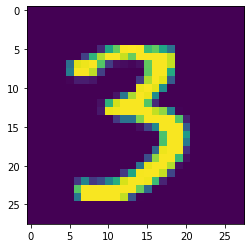

Label for digit 10,000: 3


In [2]:
# Examine one entry from MNIST Dataset
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cuml
from sklearn.manifold import TSNE

# Plot the 10,000th Digit
image = np.asarray(data[10000]).squeeze()
plt.imshow(image)
plt.show()
print("Label for digit 10,000: "+str(labelData[10000]))

In [2]:
! conda list | grep cuda

cudatoolkit               10.0.130                      0    nvidia
cudnn                     7.6.0                cuda10.0_0    nvidia
cuml                      0.10.0          cuda10.0_py36_0    rapidsai
dask-cuda                 0.10.0                   py36_0    rapidsai
dask-xgboost              0.2.0.dev28      cuda10.0py36_0    rapidsai
libcudf                   0.10.0               cuda10.0_0    rapidsai
libcugraph                0.10.0               cuda10.0_0    rapidsai
libcuml                   0.10.0               cuda10.0_0    rapidsai
libcumlprims              0.10.0a191017       cuda10.0_15    rapidsai-nightly
libcuspatial              0.10.0               cuda10.0_0    rapidsai
libnvstrings              0.10.0               cuda10.0_0    rapidsai
librmm                    0.10.0               cuda10.0_0    rapidsai
libxgboost                1.0.0.SNAPSHOT       cuda10.0_1    rapidsai
nccl                      2.4.6.1              cuda10.0_0    nvidia
py-xgboost        

We now have the MNIST Image data with a shape (60000, 28, 28), and the MNIST Label data with shape (60000,). Each pixel in the image data can actually be considered as a feature that represents the image. That means each of the 60,000 images has 784 features (28 * 28)!  

In [3]:
# Reshaping to 60000 * 784
dataFlattened = data.reshape(60000,(28*28))

In [ ]:
# TAKES REALLY LONG TO RUN! LOL
# CODE BLOCK FOR SKLEARN TSNE
from sklearn.manifold import TSNE

X_embedded = TSNE().fit_transform(dataFlattened)

In [1]:
!nvidia-smi

Wed Nov 20 21:01:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   37C    P8    12W / 280W |     43MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

/bin/sh: 1: nvcc: not found


In [ ]:
# CODE BLOCK FOR RAPIDS TSNE
tsneCuml = cuml.TSNE()

tsneTransformed = tsneCuml.fit_transform(dataFlattened)

In [ ]:
## THINGS TO DO:
## TIMING ANALYSIS OF SKLEARN VS CUML
## PLOT SCATTERPLOTS OF RESULTS with segmentation based on labelData